In [1]:
import collections
import functools
import itertools
import re
import string
import timeit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

from utils import *
from topic_utils import *

In [2]:
# suppress stop words mismatch warning
import warnings
warnings.simplefilter('ignore')

### Data

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [4]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [5]:
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

In [6]:
string_agg = lambda x: list(x)

user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
user_tweets.head()

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,[America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,[People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an r...


# Huggingface library tokenization

In [7]:
import tensorflow as tf
import tokenizers
from tokenizers import Tokenizer
from tokenizers import BertWordPieceTokenizer
from tokenizers.decoders import WordPiece
from tokenizers.models import WordPiece, Unigram, BPE, WordLevel
from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers import pre_tokenizers
from tokenizers.pre_tokenizers import Digits, WhitespaceSplit
from tokenizers.processors import TemplateProcessing
from tokenizers.trainers import UnigramTrainer, WordPieceTrainer, BpeTrainer, WordLevelTrainer
from tokenizers.tools import EncodingVisualizer

import transformers

In [8]:
from pathlib import Path
if not Path('bert-base-uncased-vocab.txt'):
    !wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt

In [9]:
normalizer = normalizers.Sequence([NFD(), 
                                   StripAccents()])

pre_tokenizer = pre_tokenizers.Sequence([WhitespaceSplit(),
                                         Digits(individual_digits=False)])

post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[("[CLS]", 1), 
                    ("[SEP]", 2),
                    ("[HTAG]", 3),
                    ("[URL]", 4),
                    ("[AT]", 5)],
)

In [10]:
original = user_tweets['tweet_text'][10]
original[0]

'Buenos días princesa, que el día ya ha comenzado y tenemos que disfrutar del día juntos.\n#BuenosDiasATodos #FelizMartesATodos #18Agosto https://t.co/sFvca6gQoR'

In [11]:
preprocessed = [preprocess_string(string, special_tokens=True)
                for string in original]
preprocessed[0]

'buenos días princesa [SEP] que el día ya ha comenzado y tenemos que disfrutar del día juntos [SEP]\n[HTAG] [HTAG] [HTAG] [URL]'

In [12]:
normalized = [normalizer.normalize_str(string) 
              for string in preprocessed]
normalized[0]

'buenos dias princesa [SEP] que el dia ya ha comenzado y tenemos que disfrutar del dia juntos [SEP]\n[HTAG] [HTAG] [HTAG] [URL]'

In [13]:
pre_tokenized = [pre_tokenizer.pre_tokenize_str(string)
                 for string in normalized]
pre_tokenized[0]

[('buenos', (0, 6)),
 ('dias', (7, 11)),
 ('princesa', (12, 20)),
 ('[SEP]', (21, 26)),
 ('que', (27, 30)),
 ('el', (31, 33)),
 ('dia', (34, 37)),
 ('ya', (38, 40)),
 ('ha', (41, 43)),
 ('comenzado', (44, 53)),
 ('y', (54, 55)),
 ('tenemos', (56, 63)),
 ('que', (64, 67)),
 ('disfrutar', (68, 77)),
 ('del', (78, 81)),
 ('dia', (82, 85)),
 ('juntos', (86, 92)),
 ('[SEP]', (93, 98)),
 ('[HTAG]', (99, 105)),
 ('[HTAG]', (106, 112)),
 ('[HTAG]', (113, 119)),
 ('[URL]', (120, 125))]

### Tokenizer

In [15]:
pretrained = Tokenizer(WordPiece("bert-base-uncased-vocab.txt", unk_token="[UNK]"))
pretrained.add_tokens(["[HTAG]", "[URL]", "[AT]"])
pretrained.normalizer = normalizer
pretrained.pre_tokenizer = pre_tokenizer
pretrained.post_processor = post_processor

In [16]:
encoding = pretrained.encode(preprocessed[0])
encoding.tokens

['[CLS]',
 'buenos',
 'dia',
 '##s',
 'princes',
 '##a',
 '[SEP]',
 'que',
 'el',
 'dia',
 'ya',
 'ha',
 'come',
 '##nza',
 '##do',
 'y',
 'ten',
 '##em',
 '##os',
 'que',
 'di',
 '##sf',
 '##rut',
 '##ar',
 'del',
 'dia',
 'jun',
 '##tos',
 '[SEP]',
 '[HTAG]',
 '[HTAG]',
 '[HTAG]',
 '[URL]',
 '[SEP]']

In [17]:
visualizer = EncodingVisualizer(pretrained)
visualizer(preprocessed[0])

In [18]:
tokenizer = Tokenizer(WordPiece("bert-base-uncased-vocab.txt", unk_token="[UNK]"))
tokenizer.add_tokens(["[HTAG]", "[URL]", "[AT]"])
tokenizer.normalizer = normalizer
tokenizer.pre_tokenizer = pre_tokenizer
tokenizer.post_processor = post_processor

In [19]:
trainer = WordPieceTrainer()
tokenizer.train_from_iterator(preprocessed, trainer=trainer)
encoding = tokenizer.encode(preprocessed[1])
encoding.tokens

['[CLS]',
 'que',
 'la',
 'noche',
 'te',
 'depare',
 'un',
 'dulce',
 'descanso',
 '[SEP]',
 '¡buenas',
 'noches',
 '[SEP]',
 '[HTAG]',
 '[HTAG]',
 '[HTAG]',
 '14',
 'ago',
 '[URL]',
 '[SEP]']

In [20]:
visualizer = EncodingVisualizer(tokenizer)
visualizer(preprocessed[1])

In [21]:
documents = (user_tweets
             .iloc[:10]['tweet_text']
             .apply(long_string)
             .apply(preprocess_string)
            )

In [22]:
encoding = pretrained.encode(documents[0])
encoding.tokens

['[CLS]',
 'america',
 'and',
 'the',
 'way',
 'its',
 'government',
 'treats',
 'its',
 'people',
 'must',
 'be',
 'reformed',
 'poland',
 'police',
 'bureau',
 'is',
 'preparing',
 'for',
 'a',
 'variety',
 'of',
 'mass',
 'gathering',
 'events',
 'being',
 'planned',
 'for',
 'saturday',
 'september',
 '26',
 '2020',
 'at',
 'this',
 'time',
 'one',
 'group',
 'has',
 'been',
 'announced',
 'they',
 'will',
 'hold',
 'an',
 'event',
 'at',
 'delta',
 'park',
 'at',
 'noon',
 'why',
 'lies',
 'why',
 'h',
 '##yp',
 '##oc',
 '##ris',
 '##y',
 'why',
 'security',
 'forces',
 'why',
 'racism',
 'why',
 'cut',
 'budgets',
 'to',
 'dec',
 '##ei',
 '##ve',
 'people',
 'no',
 'trump',
 'no',
 'no',
 'no',
 'difference',
 'he',
 'has',
 'destroyed',
 'every',
 '[UNK]',
 'even',
 'if',
 'the',
 'power',
 'to',
 'negotiate',
 'deals',
 'is',
 'handed',
 'over',
 'to',
 'the',
 'presidency',
 'congress',
 'will',
 'still',
 'have',
 'the',
 'final',
 'say',
 'and',
 'judging',
 'by',
 'the',
 '

In [23]:
remove_stopwords(encoding.tokens)

['america',
 'way',
 'government',
 'treats',
 'people',
 'must',
 'reformed',
 'poland',
 'police',
 'bureau',
 'preparing',
 'variety',
 'mass',
 'gathering',
 'events',
 'planned',
 'saturday',
 'september',
 '26',
 '2020',
 'time',
 'group',
 'announced',
 'hold',
 'event',
 'delta',
 'park',
 'noon',
 'lies',
 'security',
 'forces',
 'racism',
 'cut',
 'budgets',
 'dec',
 'people',
 'trump',
 'difference',
 'destroyed',
 'every',
 'even',
 'power',
 'negotiate',
 'deals',
 'handed',
 'presidency',
 'congress',
 'still',
 'final',
 'say',
 'judging',
 'current',
 'political',
 'climate',
 'johnson',
 'fire',
 'time',
 'trump',
 'trump',
 'trump',
 'yes',
 'bid',
 'trump',
 'democratic',
 'presidential',
 'nominee',
 'joe',
 'bid',
 'warned',
 'johnson',
 'either',
 'respect',
 'ireland',
 'peace',
 'agreement',
 'else',
 'get',
 'us',
 'trade',
 'deal',
 'racism',
 'exist',
 'america',
 'example',
 'first',
 'country',
 'world',
 'idiot',
 'extended',
 'corona',
 'trump',
 'accordi

In [24]:
dicts = (documents
             .apply(pretrained.encode)
             .apply(lambda x: x.tokens)
             .apply(remove_stopwords)
             .apply(word_frequency)
            )
dicts[0]

{'trump': 23,
 'corona': 10,
 'lies': 6,
 'bid': 5,
 'america': 4,
 'people': 4,
 'racism': 4,
 '2020': 3,
 'every': 3,
 'yes': 3,
 'president': 3,
 'believe': 3,
 'justice': 3,
 'mask': 3,
 'see': 3,
 'way': 2,
 'government': 2,
 'police': 2,
 'time': 2,
 'difference': 2,
 'say': 2,
 'johnson': 2,
 'joe': 2,
 'else': 2,
 'country': 2,
 'world': 2,
 'ridiculous': 2,
 'lying': 2,
 'states': 2,
 'administration': 2,
 'proud': 2,
 'goes': 2,
 'hand': 2,
 'day': 2,
 'new': 2,
 'months': 2,
 'american': 2,
 'americans': 2,
 'much': 2,
 'vaccine': 2,
 'gin': 2,
 'without': 2,
 'bad': 2,
 'truths': 2,
 'go': 2,
 'treats': 1,
 'must': 1,
 'reformed': 1,
 'poland': 1,
 'bureau': 1,
 'preparing': 1,
 'variety': 1,
 'mass': 1,
 'gathering': 1,
 'events': 1,
 'planned': 1,
 'saturday': 1,
 'september': 1,
 '26': 1,
 'group': 1,
 'announced': 1,
 'hold': 1,
 'event': 1,
 'delta': 1,
 'park': 1,
 'noon': 1,
 'security': 1,
 'forces': 1,
 'cut': 1,
 'budgets': 1,
 'dec': 1,
 'destroyed': 1,
 'even': 

# Pipeline

In [26]:
tokenizer = Tokenizer(WordPiece("bert-base-uncased-vocab.txt", unk_token="[UNK]"))
tokenizer.add_tokens(["[HTAG]", "[URL]", "[AT]"])
tokenizer.normalizer = normalizer
tokenizer.pre_tokenizer = pre_tokenizer
tokenizer.post_processor = post_processor

In [27]:
documents = (user_tweets
             .iloc[:]['tweet_text']
             .apply(long_string)
             .apply(preprocess_string)
            )

In [28]:
trainer = WordPieceTrainer()
pretrained.train_from_iterator(documents, trainer=trainer)
encoding = pretrained.encode(documents[1])
encoding.tokens

['[CLS]',
 'اگه',
 'ایران',
 'به',
 'یمن',
 'و',
 'مقاومت',
 'کمک',
 'نکنه',
 'خاک',
 'تو',
 'سرش',
 'لطفا',
 'کسانی',
 'که',
 'واسه',
 'ایران',
 'و',
 'مردم',
 'سیل',
 'زده',
 'کمک',
 'نکردن',
 '##د',
 'نظر',
 'ند',
 '##ن',
 '🔘',
 '##پ',
 '##ه',
 '##باد',
 'سه',
 'تا',
 '۱۰۰',
 '##۰۰۰',
 'یو',
 '##رو',
 '🔘',
 '##مو',
 '##شک',
 'سو',
 '##ا',
 'کن',
 'جدا',
 'کن',
 'ببر',
 'دعا',
 'کن',
 'دون',
 '##ه',
 'ای',
 '۱۰۰',
 '##۰',
 'یو',
 '##رو',
 '🔘',
 '##نا',
 '##و',
 'غ',
 '##نی',
 '##مت',
 '##ی',
 'با',
 'خدم',
 '##ه',
 'امریکایی',
 'رایگان',
 '🔘',
 '##نا',
 '##و',
 'بدون',
 'خدم',
 '##ه',
 'ق',
 '##سط',
 '##ی',
 'ماهی',
 '۱۰۰',
 '##۰',
 'یو',
 '##رو',
 'بد',
 '##و',
 'اینو',
 '##ر',
 'بازار',
 'بعضی',
 'که',
 'میرن',
 'خارج',
 'که',
 'مثلا',
 'ازاد',
 'باشن',
 '،',
 'چنان',
 'درگیر',
 'قوانین',
 'اجباری',
 'و',
 'خ',
 '##شک',
 'در',
 'غرب',
 '##ت',
 'میشن',
 'که',
 'ازادی',
 '##ی',
 'که',
 'تو',
 'ایران',
 'داشتن',
 'براشون',
 'حس',
 '##رت',
 'و',
 'روی',
 '##ا',
 'میشه',
 'اینجا',
 'قان

In [29]:
freq_dicts = (documents
             .apply(tokenizer.encode)
             .apply(lambda x: x.tokens)
             .apply(remove_stopwords)
             .apply(word_frequency)
            )
freq_dicts[0]

{'trump': 23,
 'corona': 10,
 'lies': 6,
 'bid': 5,
 'america': 4,
 'people': 4,
 'racism': 4,
 '2020': 3,
 'every': 3,
 'yes': 3,
 'president': 3,
 'believe': 3,
 'justice': 3,
 'mask': 3,
 'see': 3,
 'way': 2,
 'government': 2,
 'police': 2,
 'time': 2,
 'difference': 2,
 'say': 2,
 'johnson': 2,
 'joe': 2,
 'else': 2,
 'country': 2,
 'world': 2,
 'ridiculous': 2,
 'lying': 2,
 'states': 2,
 'administration': 2,
 'proud': 2,
 'goes': 2,
 'hand': 2,
 'day': 2,
 'new': 2,
 'months': 2,
 'american': 2,
 'americans': 2,
 'much': 2,
 'vaccine': 2,
 'gin': 2,
 'without': 2,
 'bad': 2,
 'truths': 2,
 'go': 2,
 'treats': 1,
 'must': 1,
 'reformed': 1,
 'poland': 1,
 'bureau': 1,
 'preparing': 1,
 'variety': 1,
 'mass': 1,
 'gathering': 1,
 'events': 1,
 'planned': 1,
 'saturday': 1,
 'september': 1,
 '26': 1,
 'group': 1,
 'announced': 1,
 'hold': 1,
 'event': 1,
 'delta': 1,
 'park': 1,
 'noon': 1,
 'security': 1,
 'forces': 1,
 'cut': 1,
 'budgets': 1,
 'dec': 1,
 'destroyed': 1,
 'even': 

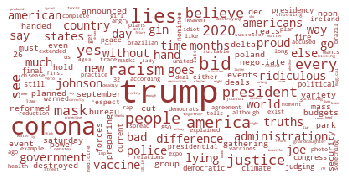

In [30]:
fig = visualize(freq_dicts[0])

## Vectorization

In [31]:
vectorizer = DictVectorizer(sparse=True)
tf = vectorizer.fit_transform(freq_dicts)

In [32]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [33]:
print(('n_samples: {}\nn_features: {}')
      .format(n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t1 = default_timer()

lda.fit(tf)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

n_samples: 2000
n_features: 1000
elapsed: 2.8880953780026175


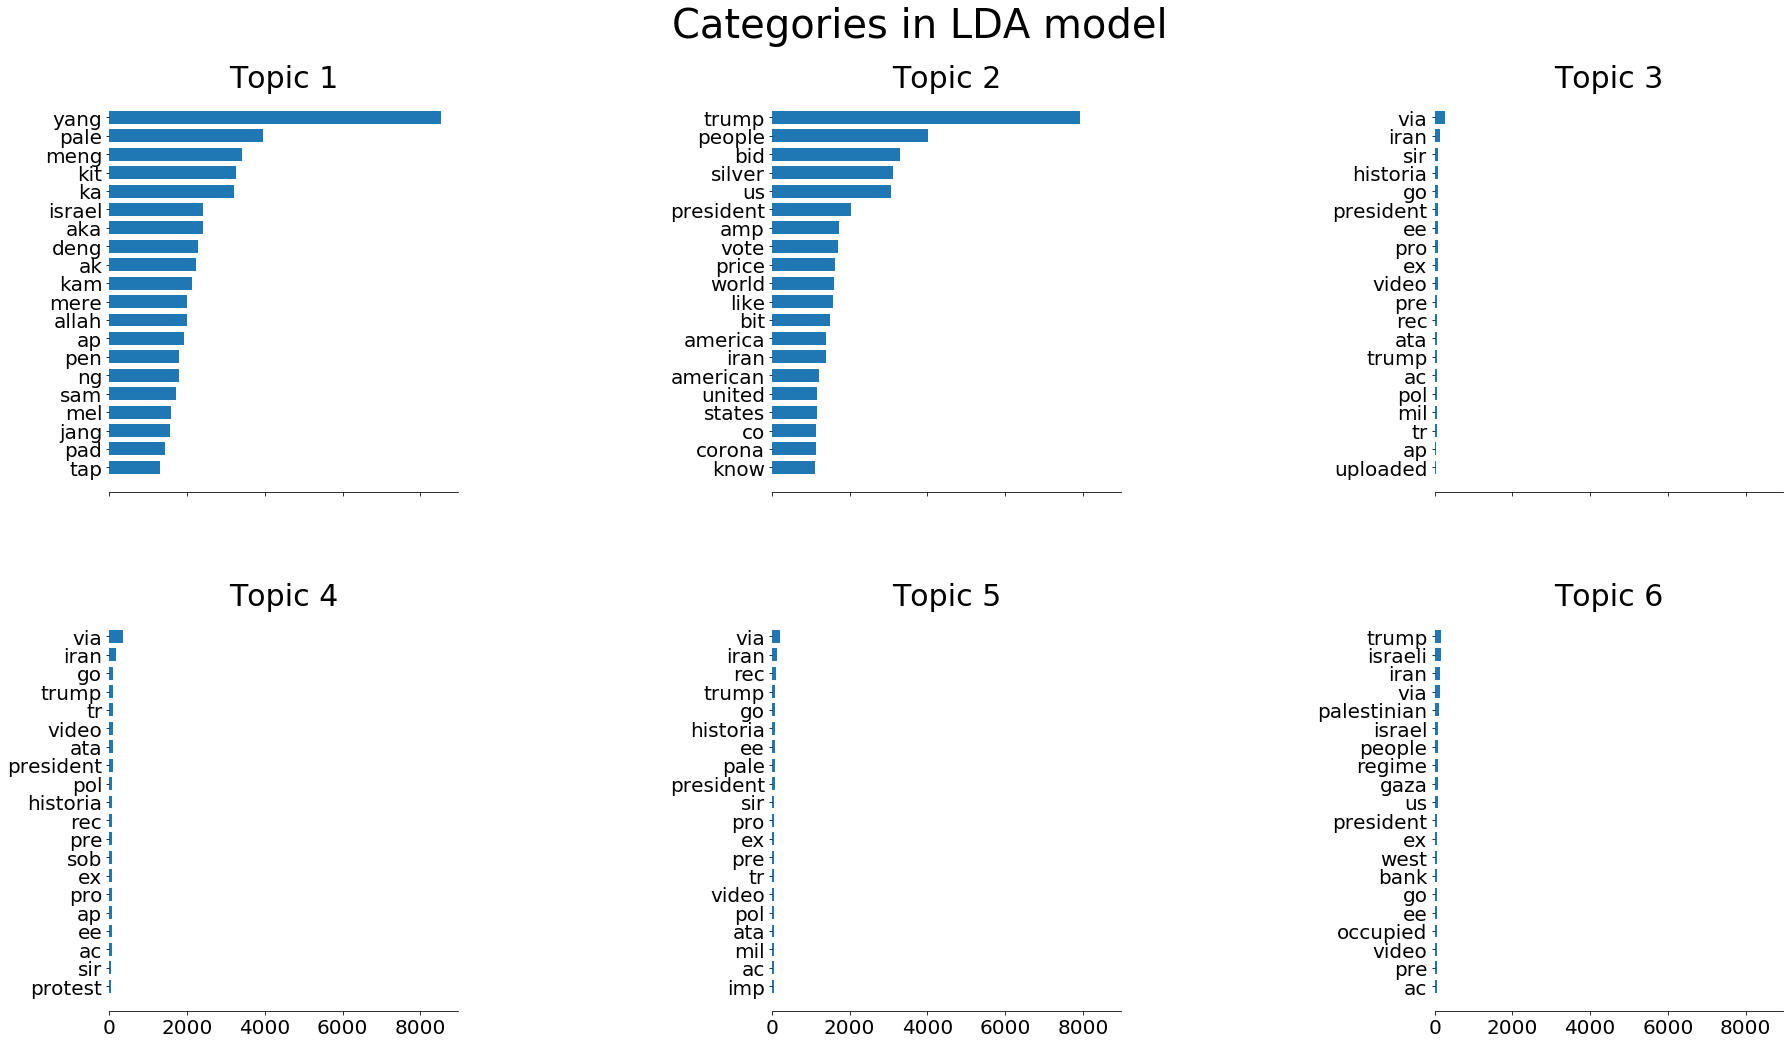

<Figure size 432x288 with 0 Axes>

In [34]:
tf_feature_names = vectorizer.get_feature_names()

plot_top_words(lda, 
               tf_feature_names, 
               n_top_words, 
               6,
               'Categories in LDA model')
plt.tight_layout()